In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from windrose import WindroseAxes
from windrose import plot_windrose
import matplotlib.cm as cm
from PIL import Image
import time
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
from fbprophet import Prophet
import math



df = pd.read_csv('preprocessed_data_15_weeks.csv')
df.ds= pd.to_datetime(df.ds)

In [2]:
df.head()

,ds,dan,temp,r_hum,co_2,aqi_i,temp_e,r_hum_e,press,wind_s,wind_a,aqi_e
0,2020-12-28 01:00:00,1.0,26.262567,40.976413,728.598900,67.941840,2.410,100.000000,998.0,7.200000,130.0,60.666667
1,2020-12-28 02:00:00,1.0,25.984767,40.775907,675.325533,65.810073,2.890,100.000000,998.0,4.600000,120.0,52.000000
2,2020-12-28 03:00:00,1.0,25.831253,40.658130,659.029267,64.538170,2.885,96.500000,999.0,5.400000,155.0,40.333333
3,2020-12-28 04:00:00,1.0,25.716143,40.527917,642.445900,64.224107,4.110,90.666667,999.0,7.700000,150.0,21.000000
4,2020-12-28 05:00:00,1.0,25.571363,40.354333,638.112600,64.128677,5.000,84.000000,999.0,5.633333,100.0,11.666667


In [3]:
#a_hum=(6.112*r_hum*math.exp((17.62*temp)/(243.12+temp)))/(461.5*(temp+273.15))
#df['a_hum'] = df.apply(lambda row: (6.112*row['r_hum']*math.exp((17.62*row['temp'])/(243.12+row['temp'])))/(461.5*(row['temp']+273.15)))
a_hum = []
counter = 0
for row in range(len(df['r_hum'])):
    ah=(6.112*df['r_hum'][row]*math.exp((17.62*df['temp'][row])/(243.12+df['temp'][row])))/(461.5*(df['temp'][row]+273.15))
    a_hum.append(ah)
df['a_hum']=a_hum
df.head()
#df=df.set_index('ds')

,ds,dan,temp,r_hum,co_2,aqi_i,temp_e,r_hum_e,press,wind_s,wind_a,aqi_e,a_hum
0,2020-12-28 01:00:00,1.0,26.262567,40.976413,728.598900,67.941840,2.410,100.000000,998.0,7.200000,130.0,60.666667,0.010100
1,2020-12-28 02:00:00,1.0,25.984767,40.775907,675.325533,65.810073,2.890,100.000000,998.0,4.600000,120.0,52.000000,0.009896
2,2020-12-28 03:00:00,1.0,25.831253,40.658130,659.029267,64.538170,2.885,96.500000,999.0,5.400000,155.0,40.333333,0.009783
3,2020-12-28 04:00:00,1.0,25.716143,40.527917,642.445900,64.224107,4.110,90.666667,999.0,7.700000,150.0,21.000000,0.009689
4,2020-12-28 05:00:00,1.0,25.571363,40.354333,638.112600,64.128677,5.000,84.000000,999.0,5.633333,100.0,11.666667,0.009570


In [4]:
df_hum=df[['ds','a_hum']].copy()

In [5]:
cap=np.round((6.112*100*math.exp((17.62*30)/(243.12+30)))/(461.5*(30+273.15)),3)
floor=np.round((6.112*20*math.exp((17.62*12)/(243.12+12)))/(461.5*(12+273.15)),3)
print(cap, floor)

0.03 0.002


In [6]:
df_hum['cap']=cap
df_hum['floor']=floor

In [7]:
df_hum.head()

,ds,a_hum,cap,floor
0,2020-12-28 01:00:00,0.010100,0.03,0.002
1,2020-12-28 02:00:00,0.009896,0.03,0.002
2,2020-12-28 03:00:00,0.009783,0.03,0.002
3,2020-12-28 04:00:00,0.009689,0.03,0.002
4,2020-12-28 05:00:00,0.009570,0.03,0.002


In [8]:
df_hum.columns=['ds','y','cap','floor']

In [9]:
df_hum.head()

,ds,y,cap,floor
0,2020-12-28 01:00:00,0.010100,0.03,0.002
1,2020-12-28 02:00:00,0.009896,0.03,0.002
2,2020-12-28 03:00:00,0.009783,0.03,0.002
3,2020-12-28 04:00:00,0.009689,0.03,0.002
4,2020-12-28 05:00:00,0.009570,0.03,0.002


In [10]:
train = df_hum.copy()
test = df_hum.copy()
train = train[0:1970]
test = test[1970:]
print(train.shape)
print(test.shape)

(1970, 4)
(490, 4)


In [11]:
train['ds']= pd.to_datetime(train['ds'])
# define the model
#specificirati cap i floor vrijednosti (prema max i min temperaturi)
#specificirati seasonality od 15 dana, kao na SARIMAX modelu
#model = Prophet() #old, without tweaking
model = Prophet(
    growth="logistic",
    seasonality_mode="multiplicative",
    #changepoint_prior_scale=0.1,
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False)#.add_seasonality(name="15 days", period=360, fourier_order=20, prior_scale=15)
#.add_seasonality(name="daily", period=24, fourier_order=150, prior_scale=50)
#.add_seasonality(name="3 hour", period=3, fourier_order=12, prior_scale=0.15)
# fit the model
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [12]:
'''# define the period for which we want a prediction
future = list()
for i in range(1, 13):
    date = '1968-%02d' % i
    future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])'''

"# define the period for which we want a prediction\nfuture = list()\nfor i in range(1, 13):\n    date = '1968-%02d' % i\n    future.append([date])\nfuture = DataFrame(future)\nfuture.columns = ['ds']\nfuture['ds']= to_datetime(future['ds'])"

In [13]:
future = pd.DataFrame(columns=['ds', 'yhat', 'yhat_lower', 'yhat_upper','cap','floor'])
future['ds'] = test['ds'].copy()
future['yhat']=np.nan
future['yhat_lower']=np.nan
future['yhat_upper']=np.nan
future['cap']=cap
future['floor']=floor
#future.columns=['ds', 'yhat', 'yhat_lower', 'yhat_upper']
#future['ds']=pd.to_datetime(future['ds'])
future.head()


,ds,yhat,yhat_lower,yhat_upper,cap,floor
1970,2021-03-22 14:00:00,NaN,NaN,NaN,0.03,0.002
1971,2021-03-22 15:00:00,NaN,NaN,NaN,0.03,0.002
1972,2021-03-22 16:00:00,NaN,NaN,NaN,0.03,0.002
1973,2021-03-22 17:00:00,NaN,NaN,NaN,0.03,0.002
1974,2021-03-22 18:00:00,NaN,NaN,NaN,0.03,0.002


                   ds      yhat  yhat_lower  yhat_upper   cap  floor
0 2021-03-22 14:00:00  0.011699    0.010782    0.012526  0.03  0.002
1 2021-03-22 15:00:00  0.011611    0.010788    0.012469  0.03  0.002
2 2021-03-22 16:00:00  0.011506    0.010682    0.012352  0.03  0.002
3 2021-03-22 17:00:00  0.011457    0.010553    0.012267  0.03  0.002
4 2021-03-22 18:00:00  0.011546    0.010732    0.012362  0.03  0.002


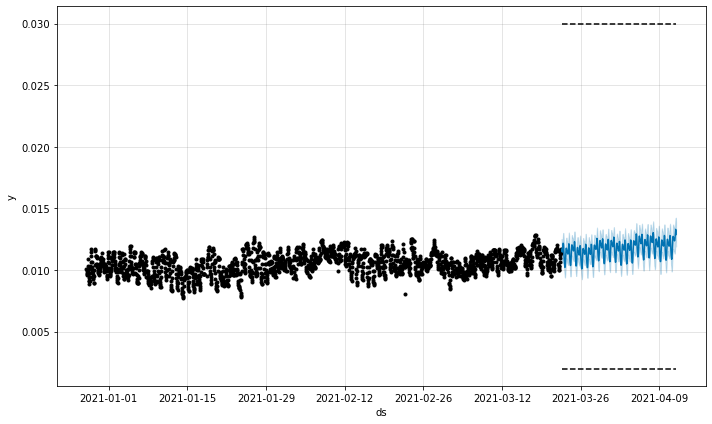

In [14]:
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'cap', 'floor']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [15]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [16]:
#preds = future[['ds','yhat']].copy()
#preds['yhat'] = forecast['yhat'].copy()
preds = pd.DataFrame({'ds': future['ds'].values, 'yhat' : forecast['yhat'].values})
preds.shape

(490, 2)

In [17]:
preds.tail()


,ds,yhat
485,2021-04-11 19:00:00,0.012796
486,2021-04-11 20:00:00,0.013123
487,2021-04-11 21:00:00,0.013300
488,2021-04-11 22:00:00,0.013211
489,2021-04-11 23:00:00,0.012881


In [18]:
test.tail()

,ds,y,cap,floor
2455,2021-04-11 19:00:00,0.012596,0.03,0.002
2456,2021-04-11 20:00:00,0.012260,0.03,0.002
2457,2021-04-11 21:00:00,0.012339,0.03,0.002
2458,2021-04-11 22:00:00,0.012217,0.03,0.002
2459,2021-04-11 23:00:00,0.011627,0.03,0.002


In [19]:
# calculate MAPE between expected and predicted values
ape_lista = []
for i in range(len(test)):
    ape_lista.append(np.absolute((preds['yhat'].values)[i] - (test['y'].values)[i]) / (test['y'].values)[i])
print((sum(ape_lista) / len(ape_lista))*100)

7.726445577041286


<ipython-input-20-35d6ac956efa>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(test['ds'][250:350],test['y'][250:350],color='c',LineWidth=1.5,label='Apsolute humidity (original)')
<ipython-input-20-35d6ac956efa>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(preds['ds'][250:350],preds['yhat'][250:350],color='k',linestyle ='dashed',LineWidth=1.5,label='Apsolute humidity (predicted)')


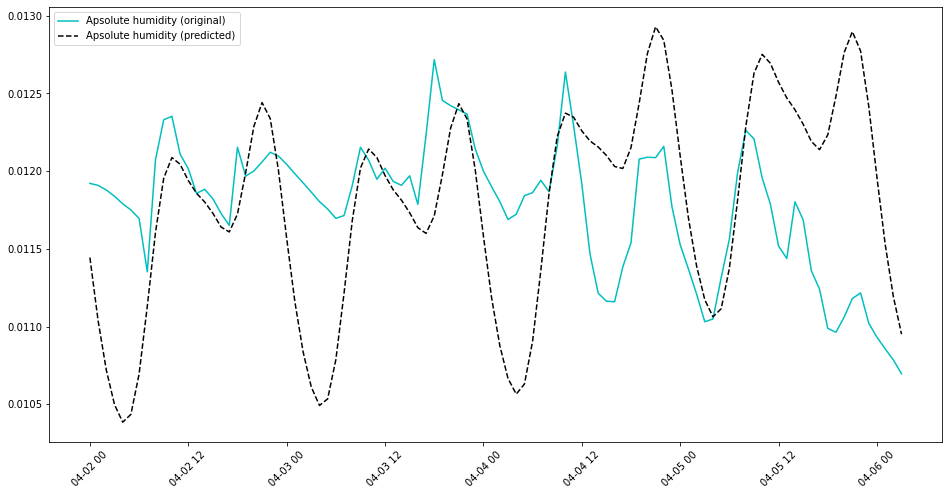

In [20]:
plt.rcParams['figure.figsize']=[16,8]
plt.rcParams.update({'font.size':10})
plt.plot(test['ds'][250:350],test['y'][250:350],color='c',LineWidth=1.5,label='Apsolute humidity (original)')
plt.plot(preds['ds'][250:350],preds['yhat'][250:350],color='k',linestyle ='dashed',LineWidth=1.5,label='Apsolute humidity (predicted)')
plt.xticks(rotation=45)
plt.legend()
plt.savefig('page_fbp.pdf',
            dpi=600,
            orientation='landscape')